# BCI Quant Take Home Assignment

This jupyter notebook will show the creation of each figure presented in the report


In [38]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from utils import download_stocks
import seaborn as sns
import warnings
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")


tickers = ['AAPL', 'AMZN', 'GOOG', 'INTC', 'ORCL', 'XOM', 'CVX', 'COP','HES', 'OXY']

date_start = '2012-01-01'
date_end = '2021-12-31'

## Q1. Normality

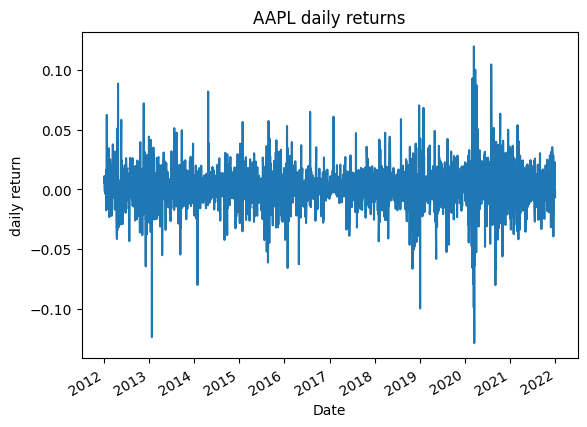

In [39]:
tname = 'AAPL'
ticker = yf.Ticker(tname)
pnl = ticker.history(start=date_start,
               		end = date_end)
close = pnl['Close']
returns = close.pct_change().dropna() #go from 0-1 to 0-100
plt.title(f"{tname} daily returns")
plt.xlabel("Year")
plt.ylabel("daily return")
returns.plot()
plt.show()

### Graphical Tests

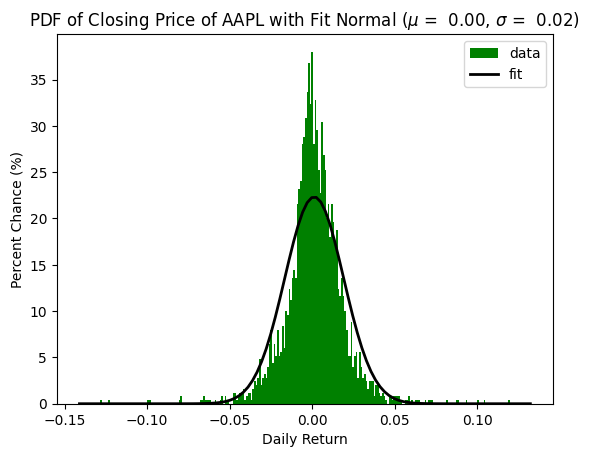

In [40]:

mean, std = norm.fit(returns)

plt.hist(returns, bins=250, density=True, color='g', label="data")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)

plt.plot(x, p, 'k', linewidth=2, label="fit")
title = f"PDF of Closing Price of {tname} with Fit Normal ($\mu$ = {mean : .2f}, $\sigma$ = {std : .2f})"
plt.title(title)
plt.legend()

plt.xlabel("Daily Return")
plt.ylabel("Percent Chance (%)")
plt.show()

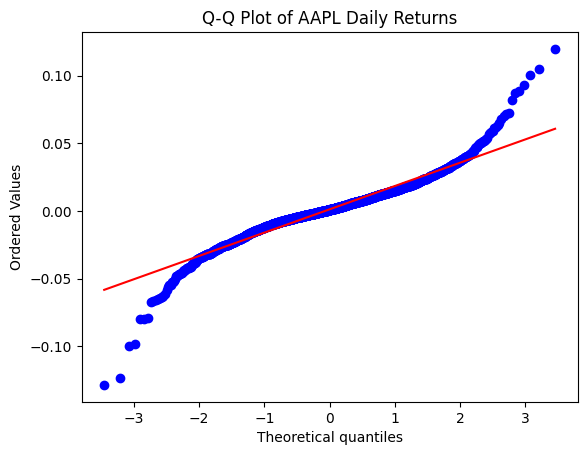

In [41]:

stats.probplot(returns, dist="norm", plot=plt)
plt.title(f"Q-Q Plot of {tname} Daily Returns")
plt.show()

#TODO : add legend

## Q2. OLS  

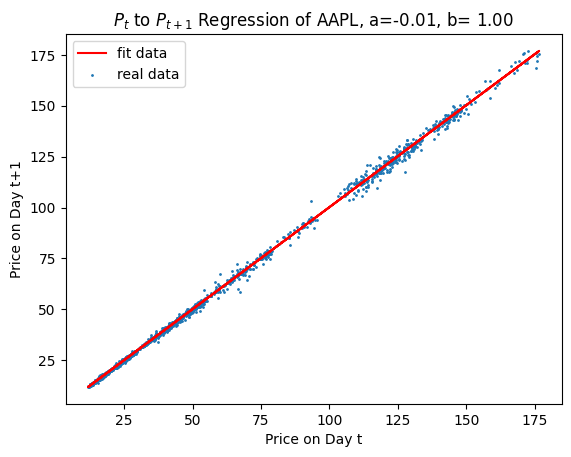

In [42]:
x_i = close.values[1:] # day t + 1
x_j = close.values[:-1] #day t

res = stats.linregress(x_j, x_i)
y = res.intercept + res.slope*x_j

plt.plot(x_j , y, "r", label="fit data")
plt.scatter(x_j, x_i, s = 1, label="real data")
plt.xlabel("Price on Day t")
plt.ylabel("Price on Day t+1")
plt.legend()
plt.title("$P_t$ to $P_{t+1}$ Regression of " + f"{tname}, a={res.intercept : .2f}, b={res.slope : .2f}")
plt.show()

# Q3. Correlations  

In [43]:
data = download_stocks(tickers, date_start, date_end)
returns = data.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HES']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


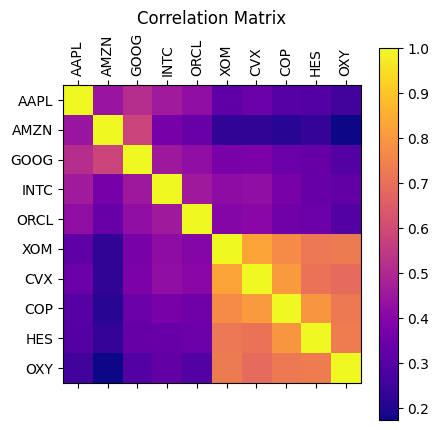

In [44]:
corr_matrix= returns.corr()
plt.matshow(corr_matrix, cmap="plasma")
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Matrix")
plt.show()

## Q4. K-means

In [ ]:
q_returns =	(data
             .resample('QE')
             .last()
             .pct_change()
             .dropna(how="all")
             .tail(7)) #last seven quarters

X = q_returns.T.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 2
random_state = 42
n_init = 1000 #with the default 10 saw high variability when changin random state (small dataset)
kmeans = KMeans(n_clusters= n_clusters, n_init = n_init, random_state=random_state)
kmeans.fit(X_scaled)

clusters = pd.DataFrame({
    "Clusters":kmeans.labels_
}, index = X.index)

clusters


,Clusters
AAPL,0
AMZN,0
GOOG,0
INTC,0
ORCL,0
XOM,0
CVX,0
COP,0
HES,1
OXY,1


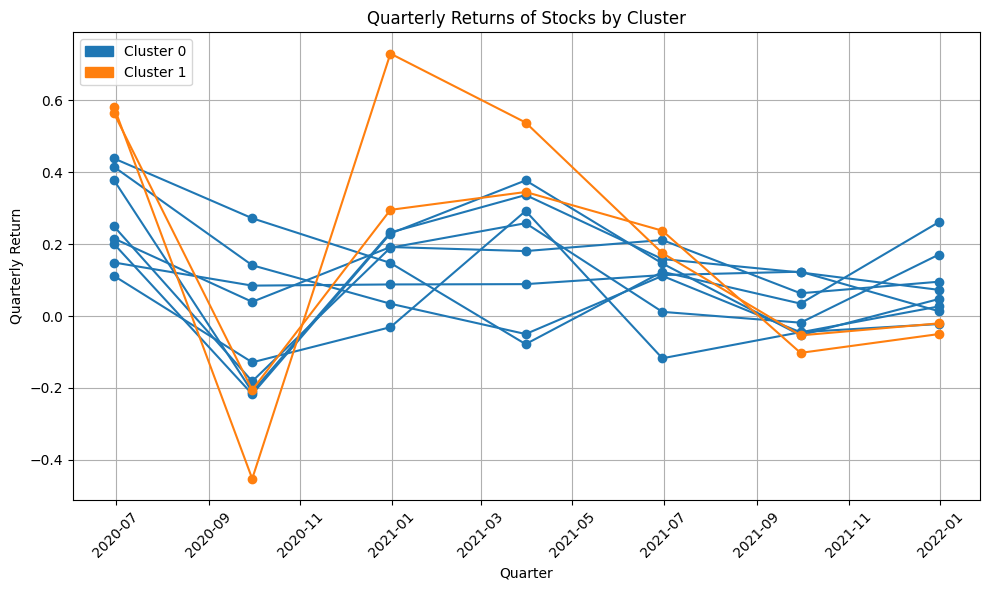

In [ ]:
#plot the q-returns, color by cluster
plt.figure(figsize=(10, 6))

for i, ticker in enumerate(X.index):
    cluster = kmeans.labels_[i]
    color = "C0" if cluster == 0 else "C1" 
    plt.plot(X.columns, X.loc[ticker], marker='o', color=color, label=ticker)

plt.xlabel("Quarter")
plt.ylabel("Quarterly Return")
plt.title("Quarterly Returns of Stocks by Cluster")
plt.xticks(rotation=45)
plt.grid(True)

import matplotlib.patches as mpatches
cluster0_patch = mpatches.Patch(color='C0', label='Cluster 0')
cluster1_patch = mpatches.Patch(color='C1', label='Cluster 1')
plt.legend(handles=[cluster0_patch, cluster1_patch], loc='upper left')

plt.tight_layout()
plt.show()


## Q5. GMVP  

In [47]:
data = download_stocks(tickers, start=date_start, end = date_end)
returns = data.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HES']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


In [48]:
Q_start = returns.corr() 
Q = (Q_start + Q_start.T)*0.5 # ensure sym
n = Q.shape[0] #dim

def obj(x):
    return x@Q@x

def grad(x):
    return 2*(Q @ x)

cons = ({'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1, 'jac' : lambda x:np.ones(n)})
bounds = [(0.0, 1.0) for _ in range(n)] 

x0 = np.ones(n) / n

res = minimize(obj, x0, jac = grad, method='SLSQP', bounds = bounds, 
               constraints=cons)

if not res.success:
    raise RuntimeError(f"Optimization failed! {res.message}")

x_opt = res.x

x_opt[x_opt < 1e-12] = 0.00
x_opt = x_opt / x_opt.sum()

opt_df = pd.DataFrame({'Ticker' : tickers,
              'Weight' : x_opt})

opt_df

,Ticker,Weight
0,AAPL,0.130113
1,AMZN,0.217584
2,GOOG,0.046601
3,INTC,0.118903
4,ORCL,0.158014
5,XOM,0.000000
6,CVX,0.000359
7,COP,0.062628
8,HES,0.072957
9,OXY,0.192841


## Q6. Freestyle
Follow a factor model from 
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Benchmarks

First we load in data on each ticker, and use the Fama-French Factor data set

In [49]:
data = download_stocks(tickers, start=date_start, end=date_end)
returns = data.pct_change().dropna()
returns


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HES']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


,AAPL,AMZN,GOOG,INTC,ORCL,XOM,CVX,COP,HES,OXY
Date,,,,,,,,,,
2012-01-04,0.005374,-0.008490,0.004313,0.023228,0.005800,0.000233,-0.001722,-0.004719,0.010323,0.003001
2012-01-05,0.011102,0.000563,-0.013872,0.011549,0.022299,-0.003023,-0.009802,-0.007992,-0.023752,-0.007944
2012-01-06,0.010454,0.028152,-0.013642,-0.005906,0.012787,-0.007463,-0.007241,-0.007784,-0.020482,-0.003952
2012-01-09,-0.001586,-0.022178,-0.042399,0.008713,0.005955,0.004464,0.010895,0.003854,0.008519,0.012112
2012-01-10,0.003580,0.004368,0.001092,0.004711,-0.002220,0.002573,-0.003928,0.004661,0.029123,0.009801
...,...,...,...,...,...,...,...,...,...,...
2021-12-23,0.003644,0.000184,0.001317,0.006671,-0.001558,0.000492,0.002411,0.001548,-0.008370,-0.002420
2021-12-27,0.022975,-0.008178,0.006262,0.012278,-0.002006,0.014258,0.020445,0.028374,0.028847,0.027383
2021-12-28,-0.005767,0.005844,-0.010914,-0.003465,-0.009940,-0.003232,-0.001936,-0.001229,-0.004368,-0.005398


In [50]:
ff_fname = "F-F_Research_Data_5_Factors_2x3_daily.csv"
ff = pd.read_csv(ff_fname)

ff["Date"] = pd.to_datetime(ff["Date"], format="%Y%m%d")
ff = ff.set_index("Date")
ff = ff.div(100) #100-0 -> 1-0 
ff.columns.values

array(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF'], dtype=object)

Now, make a dictionary to contain each tickers features and target

In [51]:
feat_frames = {}
for t in tickers:
    if t not in returns.columns:
        continue
    df = pd.DataFrame(index=returns.index)
    df["ret"] = returns[t]
    df["mom5"] = df["ret"].rolling(5).mean()
    df["mom10"] = df["ret"].rolling(10).mean()
    df["mom20"] = df["ret"].rolling(20).mean()
    df["vol20"] = df["ret"].rolling(20).std()
    df = df.join(ff, how="inner")
    df = df.dropna(how='any')
    feat_frames[t] = df

In [52]:
targets = {}
for t, df in feat_frames.items():
    # ensure ret and RF present
    s_ret = df["ret"]
    s_rf  = df["RF"]
    # shift -1 for next days
    target = s_ret.shift(-1) - s_rf.shift(-1)
    # align features to target and drop NA
    full_df = df.join(target.rename("target"), how="left")
    full_df = full_df.dropna(subset=["target"])
    feat_frames[t] = full_df  
    targets[t] = full_df["target"]

Train a model for each ticker

In [53]:


test_start = "2017-01-01"
test_end = "2021-01-01"

predictions = []
feature_cols = ["ret", "mom5", "mom20", "vol20",
                "Mkt-RF","SMB","HML", "RMW", "CMA"]

for t, df in feat_frames.items():

    X = df[feature_cols]
    y = df["target"]

    train_mask = (X.index < test_start) | (X.index > test_end)
    test_mask  = (X.index >= test_start) & (X.index <=test_end)

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test   = X[test_mask],  y[test_mask]

    if len(X_test) == 0:
        continue

    model = XGBRegressor(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions.append(pd.DataFrame({
        "ticker": t,
        "date": X_test.index,
        "actual": y_test,
        "predicted": y_pred
    }))

predictions_df = pd.concat(predictions).set_index(["ticker", "date"]).sort_index()


Let's test how well this models does

In [54]:
pred_sign = np.sign(predictions_df["predicted"])
act_sign  = np.sign(predictions_df["actual"])
directional_accuracy = (pred_sign == act_sign).groupby(level=0).mean()

print("Directional Accuracy per Stock:\n", directional_accuracy)
print("\nAverage Accuracy:", directional_accuracy.mean())


Directional Accuracy per Stock:
 ticker
AAPL    0.512413
AMZN    0.484608
COP     0.503476
CVX     0.499503
GOOG    0.523337
HES     0.519364
INTC    0.505462
ORCL    0.478649
OXY     0.509434
XOM     0.494538
dtype: float64

Average Accuracy: 0.5030784508440913


In [55]:
r2_scores = predictions_df.groupby(level=0).apply(
    lambda d: r2_score(d["actual"], d["predicted"])
)
print("\nR^2 Scores per Stock:\n", r2_scores)
print("\nAverage R^2:", r2_scores.mean())



R^2 Scores per Stock:
 ticker
AAPL   -0.113494
AMZN   -0.174432
COP    -0.086860
CVX    -0.129732
GOOG   -0.118373
HES    -0.117733
INTC   -0.069918
ORCL   -0.197124
OXY    -0.096879
XOM    -0.150973
dtype: float64

Average R^2: -0.12555187752967056


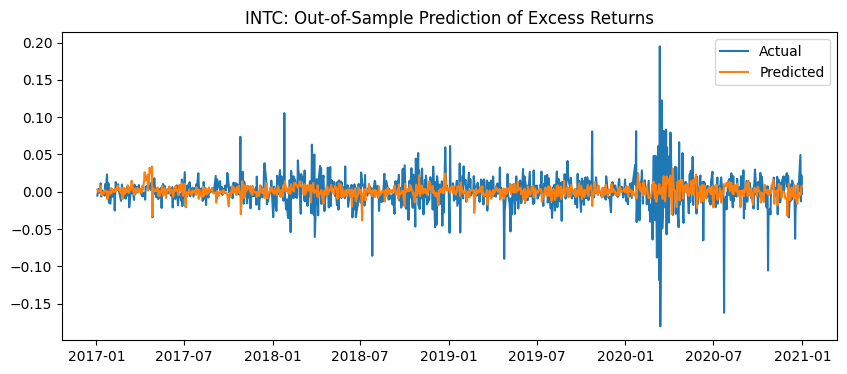

In [56]:
ticker = "INTC"
df_plot = predictions_df.loc[ticker]

plt.figure(figsize=(10,4))
plt.plot(df_plot["actual"], label="Actual")
plt.plot(df_plot["predicted"], label="Predicted")
plt.title(f"{ticker}: Out-of-Sample Prediction of Excess Returns")
plt.legend()
plt.show()
